#### Define a target metric to measure user engagement.

GemStones' innovative solutions are better alternatives to bank accounts, they are convenient and easy to use.

The business goal of every company is to have growth and be profitable via the services it offers to customers. A business organization like GemStones has this as a goal. In order to realize it, GemStones is keenly concerned with customer engagement and churn, these components of the business go a long way in determining the overall success of the company.

In understanding customer engagement via behaviour, the following are likely questions that the business needs to answer with data:
- What gets our users to come back to our product?
- What do our users do when they are engaged with and interested in our product?
- What are the actions that provide our users repeat value?
- How often does it make sense for our users to take those actions? Daily? Weekly? Monthly? or once in a long while?

Actions taken on the GemStones app can be collected into the following list regarding “engagement”, these are click events on the various products e.g.

- Clicking on Funds Transfer menu with sub menu items(fund wallet, transfer money, add beneficiary)
- Scrolling the transaction history view of the Funds Transfers product

In the context of the datasets provided for this analysis, the target metric to measure user engagement can be defined as: <br>`The total number of unique active users in a month '(Monthly Active Users (MAU))'`

An engaged user can be defined as a user that carries out transactions via any of the GemStones products in a month.<br>
An unengaged user can be defined as a user that does not carry out any transaction in a month.

Payment is part of everyday life, users pay for groceries, that cup of cappuccino to start the day, a transfer to a loved one,
paying for dinner at a vacation hotel or donating to a good cause, GemStones products can be labeled as "good market fit" for all of these customer activitities


#### Target metrics analyses

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, time
import seaborn as sns
sns.set();

In [2]:
# read in data files
df_users = pd.read_csv('../data/users.csv', parse_dates=['created_date'])
df_transactions = pd.read_csv('../data/transactions.csv', parse_dates=['created_date'])

In [3]:
# view the data
df_transactions.head()

,transaction_id,transactions_type,transactions_currency,amount,merchant_country,user_id,created_date
0,transaction_0,TRANSFER,AED,4.55,NaN,user_898,2018-04-03 03:34:21.784487
1,transaction_1,CARD_PAYMENT,AED,15.50,ARE,user_1652,2019-03-19 06:15:59.537032
2,transaction_2,CARD_PAYMENT,AED,43.40,ARE,user_1652,2019-03-18 18:53:41.323032
3,transaction_3,TRANSFER,AED,10043.01,NaN,user_1652,2019-03-22 14:20:01.513032
4,transaction_4,CARD_PAYMENT,AED,43.81,ARE,user_5509,2019-03-22 05:42:50.316652


In [4]:
# view the data
df_users.head()

,user_id,birth_year,country,created_date,plan
0,user_0,1989,PL,2018-01-13 05:15:15.599466,STANDARD
1,user_1,1975,GB,2018-01-29 03:38:46.676876,STANDARD
2,user_2,1987,PL,2018-01-18 19:17:31.229096,STANDARD
3,user_3,1994,FR,2018-01-15 18:47:56.723104,STANDARD
4,user_4,1985,GB,2018-01-11 00:36:46.673673,STANDARD


In [5]:
# view shape of data
print('Rows: ', df_transactions.shape[0])
print('Colunms: ', df_transactions.shape[1])

Rows:  2740075
Colunms:  7


In [6]:
print('Rows: ', df_users.shape[0])
print('Colunms: ', df_users.shape[1])

Rows:  19430
Colunms:  5


In [7]:
# check number of users
len(df_users.user_id.unique())

19430

In [8]:
# Check for duplicate records
df_users.duplicated().sum()

0

In [9]:
df_transactions.duplicated().sum()

0

In [19]:
# check for missing values
df_users.isnull().sum()

user_id         0
birth_year      0
country         0
created_date    0
plan            0
dtype: int64

In [20]:
# check for missing values
df_transactions.isnull().sum()

transaction_id                 0
transactions_type              0
transactions_currency          0
amount                         0
merchant_country         1158979
user_id                        0
created_date                   0
year_month                     0
dtype: int64

Missing values observed in transactions, this will be fixed before model development

In [10]:
# Transform created_date to aid analysis
df_transactions['year_month'] = df_transactions['created_date'].dt.to_period('M')
df_transactions.head()

,transaction_id,transactions_type,transactions_currency,amount,merchant_country,user_id,created_date,year_month
0,transaction_0,TRANSFER,AED,4.55,NaN,user_898,2018-04-03 03:34:21.784487,2018-04
1,transaction_1,CARD_PAYMENT,AED,15.50,ARE,user_1652,2019-03-19 06:15:59.537032,2019-03
2,transaction_2,CARD_PAYMENT,AED,43.40,ARE,user_1652,2019-03-18 18:53:41.323032,2019-03
3,transaction_3,TRANSFER,AED,10043.01,NaN,user_1652,2019-03-22 14:20:01.513032,2019-03
4,transaction_4,CARD_PAYMENT,AED,43.81,ARE,user_5509,2019-03-22 05:42:50.316652,2019-03


In [11]:
# Aggregate records
df_transactions_grouped = df_transactions.groupby(by=['year_month','user_id'], as_index=False).count()[['year_month','user_id']]
df_transactions_grouped.rename(columns={"year_month": "month", "user_id": "active_user"}, inplace=True)
df_transactions_grouped.head()

,month,active_user
0,2018-01,user_0
1,2018-01,user_1
2,2018-01,user_10
3,2018-01,user_100
4,2018-01,user_1000


The table above shows a view of users that did transactions grouped by the month the transactions were done.

In [12]:
# Aggregate records
df_transactions_plot = df_transactions.groupby(by='year_month', as_index=False).agg({'user_id': pd.Series.nunique})
df_transactions_plot.rename(columns={"year_month": "month", "user_id": "active_user_count"}, inplace=True)

In [13]:
def get_inactive_user_count(month, df_usrs, df_trxs):
    '''extracts active users from the userbase and counts the number not active for the month.'''
    df_current_month = df_trxs[df_trxs['month'] == month]  
    df_inactive_users = df_usrs[~df_usrs['user_id'].isin(df_current_month.active_user.to_list())]
    return len(df_inactive_users)

In [14]:
# Get inactive user count
df_transactions_plot['inactive_user_count'] = df_transactions_plot.apply(lambda row: get_inactive_user_count(row['month'], df_users, df_transactions_grouped), axis=1)
df_transactions_plot.head()

,month,active_user_count,inactive_user_count
0,2018-01,778,18652
1,2018-02,1301,18129
2,2018-03,2771,16659
3,2018-04,3037,16393
4,2018-05,4138,15292


The table above is an extraction of the monthly count of active and inactive users

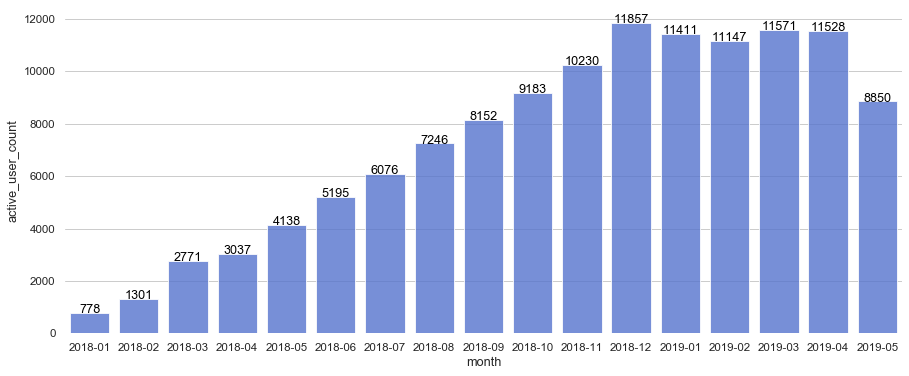

In [22]:
# plot the count of monthly active users
sns.set(style="whitegrid",font_scale=1.05)
sns.set_color_codes("pastel")
ax = plt.subplots(figsize=(15,6))
bplot = sns.barplot(x='month',y='active_user_count', data=df_transactions_plot, color='royalblue',alpha=0.8)

for index, row in df_transactions_plot.iterrows():
    bplot.text(row.name,row.active_user_count, round(row.active_user_count,2), color='black', ha="center");
    
# Add informative axis label
sns.despine(left=True, bottom=True)

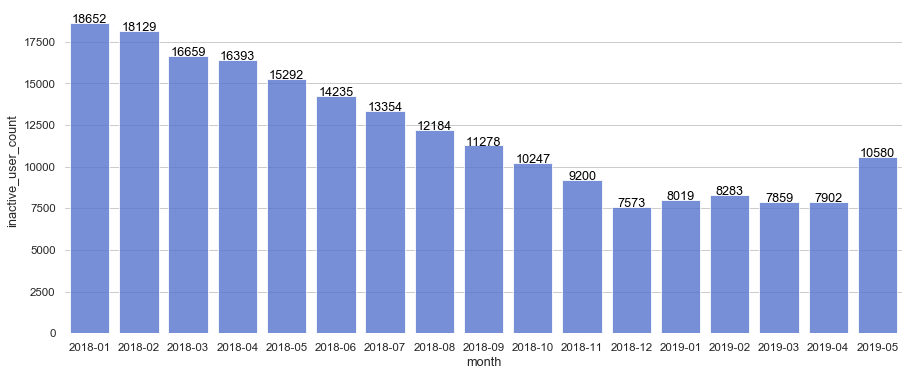

In [23]:
# plot the count of monthly inactive users
sns.set(style="whitegrid",font_scale=1.05)
sns.set_color_codes("pastel")
ax = plt.subplots(figsize=(15,6))
bplot = sns.barplot(x='month',y='inactive_user_count', data=df_transactions_plot,alpha=0.8, color='royalblue')

for index, row in df_transactions_plot.iterrows():
    bplot.text(row.name,row.inactive_user_count, round(row.inactive_user_count,2), color='black', ha="center");

sns.despine(left=True, bottom=True)

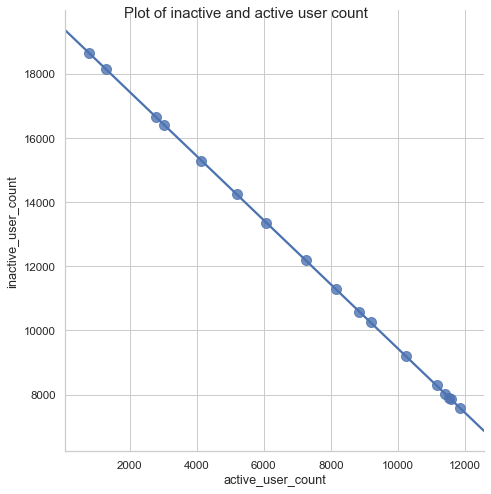

In [17]:
# Create lmplot
sns.set(style="whitegrid",font_scale=1.05)
lm = sns.lmplot(y='inactive_user_count', x='active_user_count',data= df_transactions_plot, height=7, truncate=False, scatter_kws={"s": 100})
fig = lm.fig 
fig.suptitle('Plot of inactive and active user count', fontsize=15)
plt.show()

From the active_user_count plot, there is a steady rise in the number of monthly active users. The steady month on month rise possibly depicts a new feature or new product launch to an existing user base.

Observations from the plot of inactive and active user count, it shows a correlation between the 'active_user_count' and 'inactive_user_count' this further speaks to the monthly active user rise.

A noticeable step difference which is higher than previous bar differences can be observed between 2018-11 and 2018-12, this sharp increase was likely triggered by festivity, the range 2018-11 to 2018-12 is largely filled with various Christmas season activities like vacationing, shopping and parties.

The monthly active user metric is good to use in measuring user engagement.